In [97]:
! pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.4 MB/s eta 0:00:00


In [1]:
! wget https://www.ebi.ac.uk/ena/browser/api/embl/CP048767.1 -O bacteria.embl

--2024-04-19 04:22:22--  https://www.ebi.ac.uk/ena/browser/api/embl/CP048767.1
Resolving www.ebi.ac.uk (www.ebi.ac.uk)... 193.62.193.80
Connecting to www.ebi.ac.uk (www.ebi.ac.uk)|193.62.193.80|:443... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [text/plain]
Saving to: ‘bacteria.embl’

bacteria.embl           [            <=>     ]   3.78M  1.19MB/s    in 3.2s    

2024-04-19 04:22:26 (1.19 MB/s) - ‘bacteria.embl’ saved [3963923]



In [2]:
! gdown 1nn6dYxByKYnWuNJkp2FNsbyNq4eDgucj

Downloading...
From (original): https://drive.google.com/uc?id=1nn6dYxByKYnWuNJkp2FNsbyNq4eDgucj
From (redirected): https://drive.google.com/uc?id=1nn6dYxByKYnWuNJkp2FNsbyNq4eDgucj&confirm=t&uuid=e94c7717-3c5a-4795-b7b4-d987740993dd
To: /content/extractintergene.py
100% 1.86k/1.86k [00:00<00:00, 9.07MB/s]


In [3]:
! python extractintergene.py bacteria.embl

654
1608273


In [4]:
! head intergenes.fasta

>intergene1 1324 1482
gtgaaaggatgtgaaaaataaattctagagtgtgaaaaaaagaaattaagcaaagtatgataaaatacaaatttgattattttgctttgaagaatttcacaatttcaacaagcttattattacaacgaatttaaaattaaaataaaccaaggagaaaaa
>intergene2 2551 2578
taaaacaagtaaaagataaaggaaaaat
>intergene3 4889 4913
atttatcattgaagaaatcatttct
>intergene4 6497 6699
tgaaatatccttatatttttatgatttttttattttattataaattttaggaatttaaataattgattatattaatctttttgattaaaaaaaataattatttttataattttgcatattaaaataaaatcatcatatgttcgagttttattacattttaactaagttttttctacaattaaatttttaaaattatttaagga
>intergene5 8008 8140
tttttgcaaatctatcaaaatattttttaatttatttatttttaagataaaaattatatcgattttaaaacaatgtatgctataatccttataaagctaacaaaatttaaatcagtcttataaggagagcaaa


In [5]:
starts = []
stops = []
seqs = []

with open('intergenes.fasta', 'r') as f:
    for line in f:
        if line[0] == '>':
            starts.append(int(line.split(' ')[1]))
            stops.append(int(line.split(' ')[2][:-1]))
        else:
            seqs.append(line[:-1].upper())

In [6]:
assert len(starts) == len(stops) == len(seqs)

In [98]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Seq import Seq

In [8]:
df = pd.DataFrame({'start': starts, 'stop': stops, 'seq': seqs})
df_new = df.sample(frac=1, random_state=42)
df_new

,start,stop,seq
333,787021,787215,ATCAATACCTGTTGCACTCTTAGTTTTTCCAAATTTGGATCTAAGG...
78,165244,165321,TAGTTTTCCTTAAAAATTAAAACAATAAGCCGTGATTATAAATTAT...
503,1264841,1264884,AAATTTGCTATAATTTTACTTTTAAAATTTTTAGGAGTTTTTGC
290,674552,675277,TAAAAAAGATTTGAATAAAGAAGCTTTAAAATCTAAAGCAAGTATA...
360,844642,844675,AACTTATCAAAGCCCTTTTTGGGCTTTTTTCTAT
...,...,...,...
71,144825,144944,AATTTAGTTTTACTTATCTTTTTGAATTAAAGTCTAATATAAAGTA...
106,218760,218862,TGAAATTTCCTAAAAGTTAATTTTTAAATGATTATTTTAGCTAAAT...
270,632745,632772,TTTAAAATAAAATAAAAAAGGATTCAAG
435,1070647,1070761,GAGTTTCTCCTTATAAATTTAGCTTTATTCCTCCACATCCCTTAAT...


In [9]:
df_train = df_new.iloc[:df_new.shape[0]//2, :]
df_test = df_new.iloc[df_new.shape[0]//2:, :]

In [40]:
print(df_train.shape, df_test.shape)

(327, 3) (327, 3)


# Define models

In [54]:
class Bernoulli:
    # 0-order Markov model
    def __init__(self, dataframe):
        self.df = dataframe
        self.letter_prob = dict()
        seqs = []
        log_length = []
        for i in range(dataframe.shape[0]):
            seqs.append(dataframe.iloc[i, 2])
            log_length.append(np.log(len(dataframe.iloc[i, 2])))

        self.log_mean = np.mean(log_length)
        self.log_std = np.std(log_length)

        self.pdf_vals = norm(self.log_mean, self.log_std).pdf(np.log([i for i in range(20, 10000)]))
        self.pdf_sum = np.sum(self.pdf_vals)
        self.pdf_values_normed = {int(i):norm(self.log_mean, self.log_std).pdf(np.log(i)) / self.pdf_sum for i in range(20, 10000)}

        values, counts = np.unique(list(''.join(seqs)), return_counts=True)
        assert len(values) == 4
        for i in range(len(values)):
            self.letter_prob[values[i]] = counts[i] / np.sum(counts)

    def predict(self, sequence):
        prob = 0
        for l in sequence:
            prob += np.log(self.letter_prob[l])

        return prob + np.log(self.pdf_values_normed[len(sequence)])

    def get_param_num(self):
        num_param = len(self.letter_prob.keys())
        return num_param

    def get_aic(self):
        total_prob = 0
        for seq in self.df.seq:
            total_prob += self.predict(seq)

        return 2 * self.get_param_num() - 2 * total_prob

    def get_bic(self):
        total_prob = 0
        for seq in self.df.seq:
            total_prob += self.predict(seq)

        return np.log(self.df.shape[0]) * self.get_param_num() - 2 * total_prob


class Markov:
    def __init__(self, dataframe, order):
        assert order != 0

        log_length = []
        for i in range(dataframe.shape[0]):
            log_length.append(np.log(len(dataframe.iloc[i, 2])))

        self.log_mean = np.mean(log_length)
        self.log_std = np.std(log_length)

        self.pdf_vals = norm(self.log_mean, self.log_std).pdf(np.log([i for i in range(20, 10000)]))
        self.pdf_sum = np.sum(self.pdf_vals)
        self.pdf_values_normed = {int(i):norm(self.log_mean, self.log_std).pdf(np.log(i)) / self.pdf_sum for i in range(20, 10000)}

        self.df = dataframe
        self.order = order

        alphabet = ['A', 'T', 'C', 'G']
        kmeres = [''.join(list(x)) for x in itertools.product(alphabet, repeat=order)]
        self.init_letter_prob = {kmere:0 if order < 3 else 1 for kmere in kmeres}
        self.comb_letter_prob = {kmere:dict() for kmere in kmeres}
        for kmere in kmeres:
            for letter in alphabet:
                self.comb_letter_prob[kmere][letter] = 0 if order < 3 else 1
        # print(self.comb_letter_prob)

        # compute initial probs
        for seq in dataframe.seq:
            self.init_letter_prob[seq[:order]] += 1

        found_elements = sum(self.init_letter_prob.values())
        for k, v in self.init_letter_prob.items():
            self.init_letter_prob[k] /= found_elements

        total_sum = 0
        for k, v in self.init_letter_prob.items():
            total_sum += v
        assert round(total_sum) == 1

        # print(self.init_letter_prob)

        # compute transition probs
        for seq in dataframe.seq:
            for i in range(len(seq) - order):
                window = seq[i:i+order+1]
                self.comb_letter_prob[window[:-1]][window[-1]] += 1

        for k, v in self.comb_letter_prob.items():
            letter_sum = sum(list(v.values()))
            for kk in v.keys():
                v[kk] /= letter_sum

        # print(self.comb_letter_prob)

        for k, v in self.comb_letter_prob.items():
            # print(sum(v.values()))
            assert round(sum(v.values())) == 1

    def predict(self, sequence):
        prob = 0
        prob += np.log(self.init_letter_prob[sequence[:self.order]])
        for i in range(len(sequence) - self.order):
            window = sequence[i:i+self.order+1]
            prob += np.log(self.comb_letter_prob[window[:-1]][window[-1]])

        return prob + np.log(self.pdf_values_normed[len(sequence)])

    def get_param_num(self):
        num_param = 4 * len(self.comb_letter_prob.keys()) - 1 # + len(self.init_letter_prob.keys())
        return num_param

    def get_aic(self):
        total_prob = 0
        for seq in self.df.seq:
            total_prob += self.predict(seq)

        return 2 * self.get_param_num() - 2 * total_prob

    def get_bic(self):
        total_prob = 0
        for seq in self.df.seq:
            total_prob += self.predict(seq)

        return np.log(self.df.shape[0]) * self.get_param_num() - 2 * total_prob


# Test Bernoulli

In [116]:
model = Bernoulli(df_train)

In [117]:
model.predict(df_test.iloc[0, 2])

-188.4661607323567

In [118]:
model.get_aic()

105857.27623066187

In [119]:
model.get_bic()

105872.43607134545

In [120]:
model.get_param_num()

4

In [126]:
model_qual = dict()
model_qual_rev = dict()

In [127]:
model_preds = {i:[] for i in range(4)}
model_preds_rev = {i:[] for i in range(4)}

In [128]:
for i in range(df_test.shape[0]):
    model_preds[0].append(model.predict(df_test.iloc[i, 2]))
model_qual[0] = np.sum(model_preds[0])
model_qual[0]

-48444.20693333179

In [129]:
for i in range(df_test.shape[0]):
    rev_seq = str(Seq(df_test.iloc[i, 2]).reverse_complement())
    model_preds_rev[0].append(model.predict(rev_seq))
model_qual_rev[0] = np.sum(model_preds_rev[0])
model_qual_rev[0]

-48443.53547129981

# Test Markov model

In [49]:
model = Markov(df_train, 3)

In [37]:
model.predict(df_test.iloc[0, 2])

-179.03738612446014

In [132]:
model.predict(df_test.iloc[0, 2])

-173.34768168681586

In [133]:
model.get_aic()

99384.64960744648

In [134]:
model.get_bic()

100597.4368621336

In [50]:
model.get_param_num()

256

In [70]:
for i in range(1, 10):
    model = Markov(df_train, i)
    pred_logs = []
    for j in range(df_test.shape[0]):
        pred_logs.append(model.predict(df_test.iloc[j, 2]))

    print(i, np.sum(pred_logs))

1 -47406.22540438429
2 -47228.16723982568
3 -47066.49777169606
4 -47176.29546825647
5 -47578.74843361721
6 -48480.98987669354
7 -49701.176884409746
8 -50939.27824777992
9 -52190.73756664756


In [91]:
for i in range(1, 4):
    model = Markov(df_train, i)
    print(model.get_aic(), model.get_bic())

103752.84414009168 103809.69354265514
103368.9187284435 103607.68621921002
103177.87623824322 104144.31608182202


In [130]:
for i in range(1, 4):
    model = Markov(df_train, i)
    for j in range(df_test.shape[0]):
        model_preds[i].append(model.predict(df_test.iloc[j, 2]))
    model_qual[i] = np.sum(pred_logs)

In [131]:
for i in range(1, 4):
    model = Markov(df_train, i)
    for j in range(df_test.shape[0]):
        rev_seq = str(Seq(df_test.iloc[j, 2]).reverse_complement())
        model_preds_rev[i].append(model.predict(rev_seq))
    model_qual_rev[i] = np.sum(pred_logs)

In [115]:
model_qual_rev

{0: -48443.53547129981,
 1: -47401.42290740854,
 2: -47231.30945680862,
 3: -47087.65043635509}

# Graphics

In [82]:
likelyhood_ratio_log = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        likelyhood_ratio_log[i, j] = model_qual[i] - model_qual[j]

In [113]:
likelyhood_ratio_log = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        likelyhood_ratio_log[i, j] = model_qual_rev[i] - model_qual_rev[j]

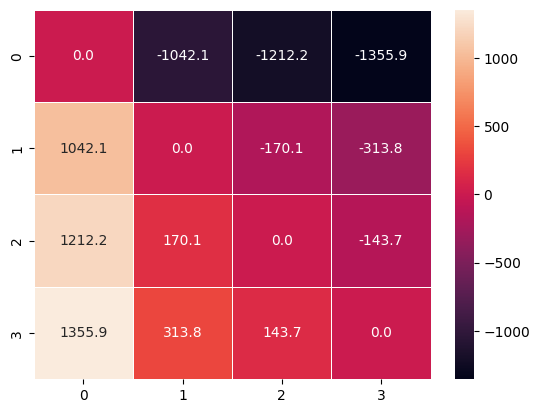

In [114]:
sns.heatmap(likelyhood_ratio_log, annot=True, fmt=".1f", linewidths=.5)
plt.savefig('likelyhood_ratio_log_rev.png')

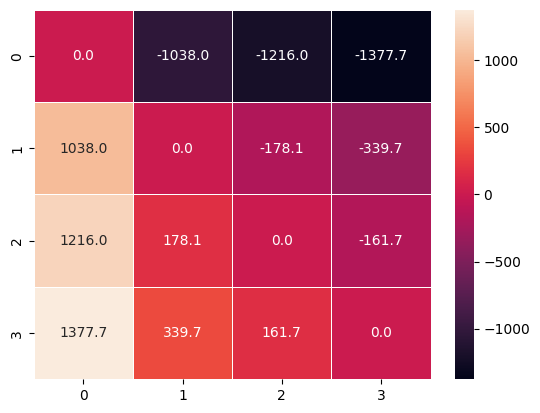

In [85]:
sns.heatmap(likelyhood_ratio_log, annot=True, fmt=".1f", linewidths=.5)
plt.savefig('likelyhood_ratio_log.png')

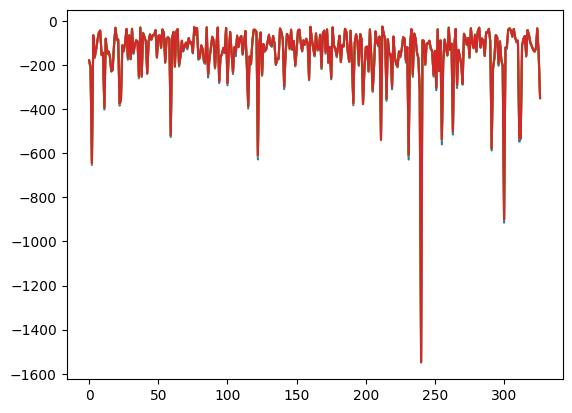

In [132]:
plt.clf()
plt.plot(model_preds[0])
plt.plot(model_preds[1])
plt.plot(model_preds[2])
plt.plot(model_preds[3])
plt.show()

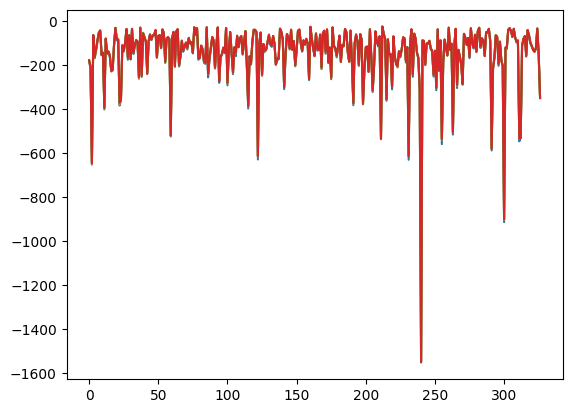

In [133]:
plt.clf()
plt.plot(model_preds_rev[0])
plt.plot(model_preds_rev[1])
plt.plot(model_preds_rev[2])
plt.plot(model_preds_rev[3])
plt.show()

In [134]:
from scipy import stats

In [141]:
stats.pearsonr(model_preds[0], model_preds[1])

PearsonRResult(statistic=0.9997608817847242, pvalue=0.0)

In [142]:
stats.pearsonr(model_preds_rev[0], model_preds_rev[1])

PearsonRResult(statistic=0.9997628744931307, pvalue=0.0)

In [146]:
stats.pearsonr([0, 1, 2, 3, 4, 5], [5, 4, 3, 2, 1, 0])

PearsonRResult(statistic=-0.9999999999999999, pvalue=0.0)

In [147]:
corrs = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        corrs[i, j] = stats.pearsonr(model_preds[i], model_preds[j]).statistic

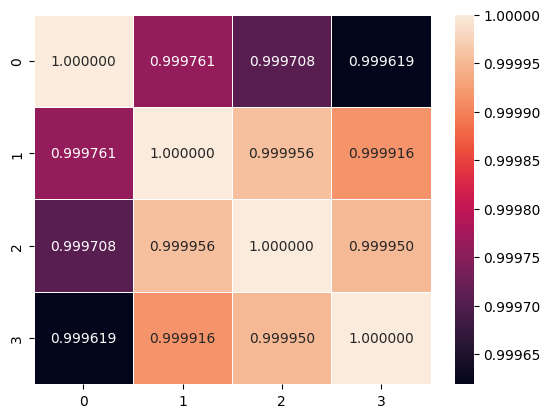

In [151]:
sns.heatmap(corrs, annot=True, fmt=".6f", linewidths=.5)
plt.savefig('corrs.png')

In [152]:
corrs_rev = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        corrs_rev[i, j] = stats.pearsonr(model_preds_rev[i], model_preds_rev[j]).statistic

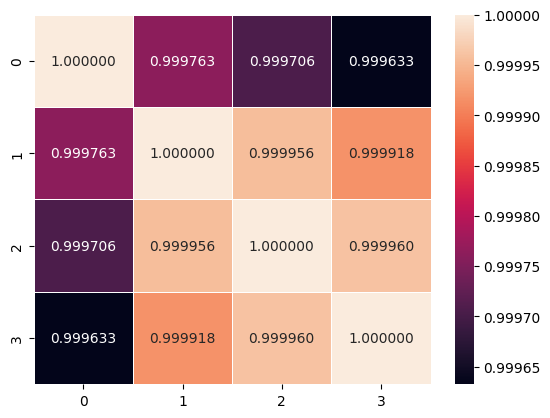

In [153]:
sns.heatmap(corrs_rev, annot=True, fmt=".6f", linewidths=.5)
plt.savefig('corrs_rev.png')

In [154]:
ks_gen = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        ks_gen[i, j] = stats.kstest(model_preds[i], model_preds[j]).pvalue

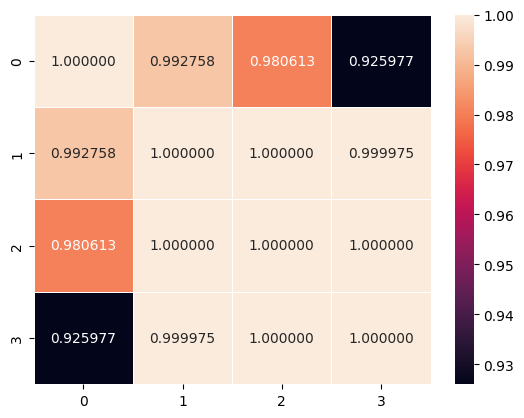

In [155]:
sns.heatmap(ks_gen, annot=True, fmt=".6f", linewidths=.5)
plt.savefig('ks.png')

In [156]:
ks_rev = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        ks_rev[i, j] = stats.kstest(model_preds_rev[i], model_preds_rev[j]).pvalue

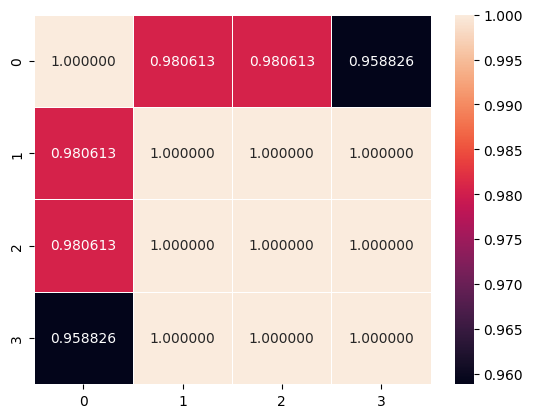

In [157]:
sns.heatmap(ks_rev, annot=True, fmt=".6f", linewidths=.5)
plt.savefig('ks_rev.png')

In [160]:
gen_pred_data = [np.sum(np.array(model_preds[0]) > np.array(model_preds[3])),
                 np.sum(np.array(model_preds[1]) > np.array(model_preds[3])),
                 np.sum(np.array(model_preds[2]) > np.array(model_preds[3]))]

In [161]:
rev_pred_data = [np.sum(np.array(model_preds_rev[0]) > np.array(model_preds_rev[3])),
                 np.sum(np.array(model_preds_rev[1]) > np.array(model_preds_rev[3])),
                 np.sum(np.array(model_preds_rev[2]) > np.array(model_preds_rev[3]))]

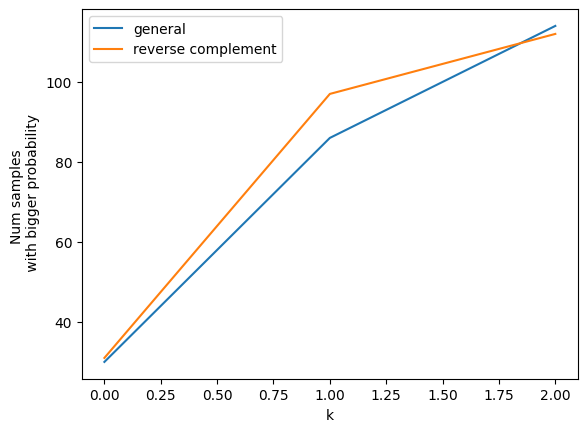

In [168]:
plt.clf()
plt.plot(gen_pred_data, label='general')
plt.plot(rev_pred_data, label='reverse complement')
plt.legend()
plt.xlabel('k')
plt.ylabel('Num samples \n with bigger probability')
plt.savefig('comparing.png')
plt.show()

In [165]:
sum(model_preds[1])

-47406.225404384284

In [164]:
sum(model_preds[3])

-47066.49777169605